In [16]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.manifold import TSNE
import mpld3
import numpy as np
from gensim.models import Word2Vec
import seaborn as sns
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.parsing.preprocessing import remove_stopwords
from tensorflow.keras.preprocessing import image

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from helper import *
from os import listdir
from os.path import isfile, join
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sharony\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sharony\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
food_train = pd.read_csv("C:/Users/sharony/Documents/school/DS_APPS/data/food_train.csv")
food_train = food_train.replace(np.nan, '', regex=True)
food_nutrients = pd.read_csv("C:/Users/sharony/Documents/school/DS_APPS/data/food_nutrients.csv")
food_nutrients = food_nutrients.replace(np.nan, '', regex=True)
food_nutrients_joined = pd.merge(food_nutrients, food_train, on="idx")
nutrients = pd.read_csv("C:/Users/sharony/Documents/school/DS_APPS/data/nutrients.csv")

### Exploratory Data Analysis

### Exploring Household full text

In [3]:
print('# Unique Values of Houshold full text:',len(food_train.household_serving_fulltext.unique()))

# Unique Values of Houshold full text: 2207


In [4]:
food_train.household_serving_fulltext.value_counts()[0:10]

1 onz        5424
0.25 cup     2116
3 pieces     1114
1 cookie     1074
2 cookies     889
4 pieces      744
1 piece       680
1 package     585
2 pieces      538
5 pieces      467
Name: household_serving_fulltext, dtype: int64

#### Are the digits important?

When we look at houshold values we see different values of numbers with the same text - 2 pieces, 3 pieces etc...<br>
We will check if there is any importance to the digits in household_serving_fulltext (is label distribution different).<br>
Let's take a look only at values that contains a digit.

In [5]:
food_train.household_serving_fulltext[food_train.household_serving_fulltext.str.contains('\d+', na=False)].value_counts()[0:20]

1 onz        5424
0.25 cup     2116
3 pieces     1114
1 cookie     1074
2 cookies     889
4 pieces      744
1 piece       680
1 package     585
2 pieces      538
5 pieces      467
1 bar         441
3 cookies     403
1/4 cup       398
1 pouch       320
1 slice       316
1.5 onz       297
2 tbsp        294
6 pieces      290
1.4 onz       275
0.5 bar       254
Name: household_serving_fulltext, dtype: int64

#### Cleaning the Column

In [6]:
food_train = clean_column(food_train,'household_serving_fulltext')

In [7]:
food_train.household_serving_fulltext.value_counts()[0:10]

1 onz        5424
025 cup      2160
3 pieces     1238
1 cookies    1160
2 cookies     914
4 pieces      838
1 pack        811
1 pieces      803
2 pieces      607
5 pieces      572
Name: household_serving_fulltext, dtype: int64

We will compare between different values of pieces and cookies to see if the number of units affects the distribution of labels.


### Plots for exploring units of household serving

We plot the categories for each quantity of household serving for "pieces" and for "cookies". 

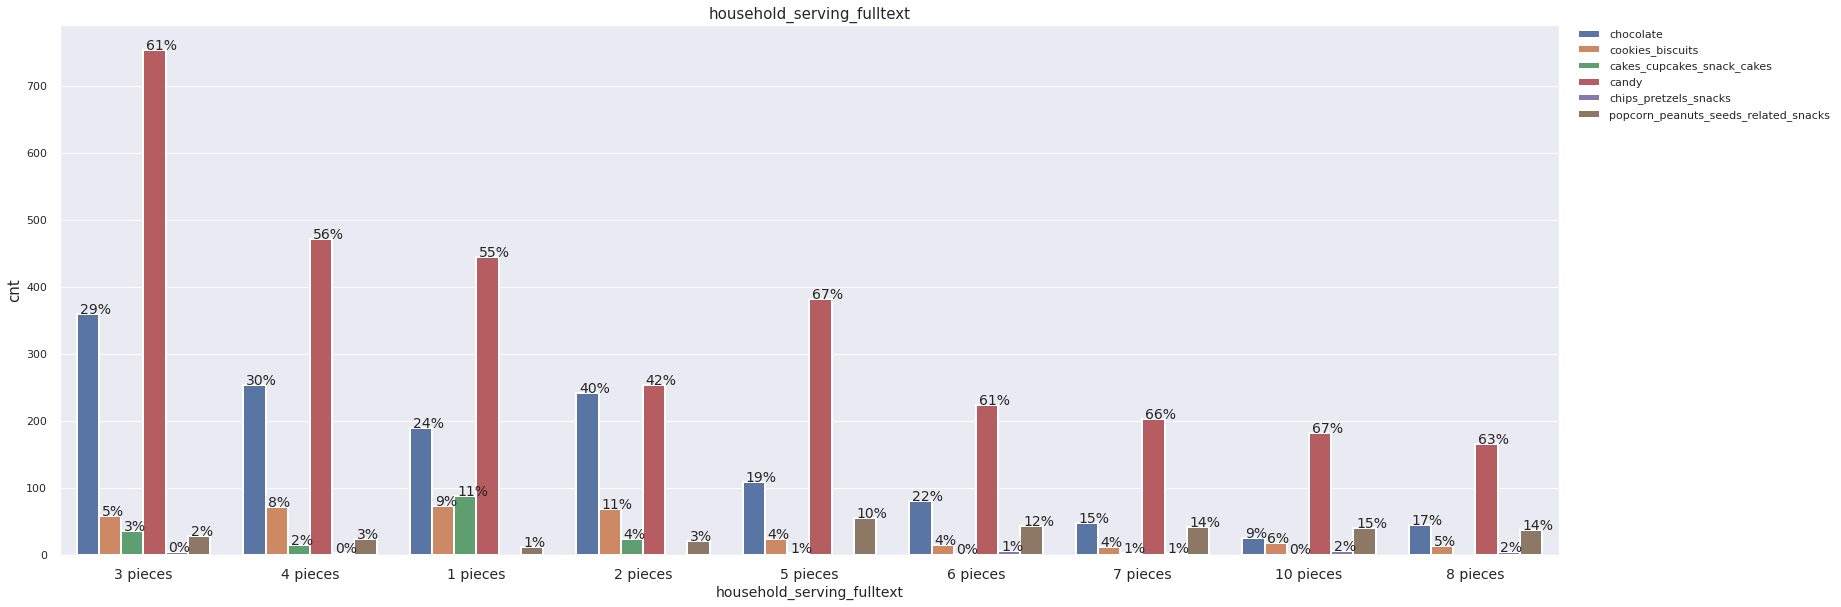

In [16]:
cnt_piece = food_train.household_serving_fulltext[food_train.household_serving_fulltext.str.contains('piece')].value_counts()
sns.set(rc={'figure.figsize':(25.7,8.27)})

ax = sns.countplot(x='household_serving_fulltext', data=food_train,
                  # facecolor=(0, 0, 0, 0),
                   linewidth=2,
                   hue = food_train.category,
                   order=cnt_piece.index[0:9]
                   #,legend=False
                  )
#ax.despine(left=True)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.tight_layout()
plt.title("household_serving_fulltext",fontsize=15)
ax.set_xlabel('household_serving_fulltext',fontsize=14)
ax.set_ylabel('cnt',fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)


with_hue(ax, food_train.household_serving_fulltext[food_train.household_serving_fulltext.str.contains('piece')], 9, 6)   

we see that "pieces" label distribution does not change much with quantity, and that the number in " # pieces" does not contain information about the label (it is quite likely to be a candy).<br> So we will assume can ignore the number, and use the word "pieces" as a feature. 

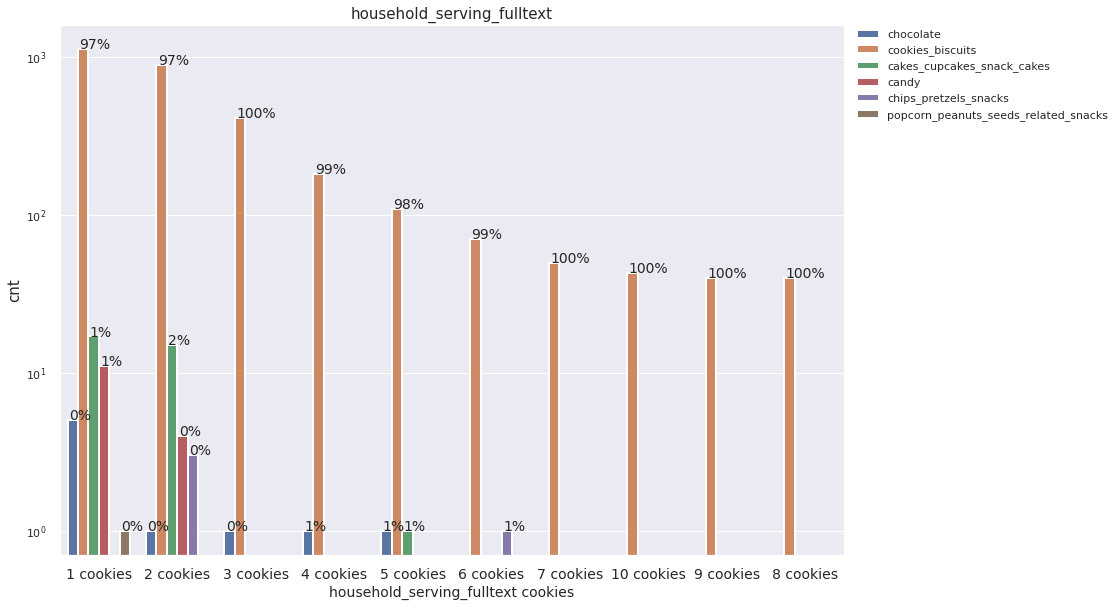

In [17]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
cnt_cookie = food_train.household_serving_fulltext[food_train.household_serving_fulltext.str.contains('cookie')].value_counts()
ax = sns.countplot(x='household_serving_fulltext', data=food_train,
                  # facecolor=(0, 0, 0, 0),
                   linewidth=2,
                   hue = food_train.category,
                   order=cnt_cookie.iloc[0:10].index
                   #,legend=False
                  )
ax.set_yscale("log")
#ax.despine(left=True)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.tight_layout()
plt.title("household_serving_fulltext",fontsize=15)
ax.set_xlabel('household_serving_fulltext cookies',fontsize=14)
ax.set_ylabel('cnt',fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

with_hue(ax, food_train.household_serving_fulltext[food_train.household_serving_fulltext.str.contains('cookie')], 10, 6)    

The same affect is observed in "cookies":<br> the unit of measurement is almost entirely correlated with one label but the quantity does not mean a lot.<br> So we can ignore the number and leave the unit as a feature.

Hence we remove the digits from household_serving_fulltext since the category distribution looks similiar both in cookies and in pieces.

In [18]:
# Clean from digits
food_train['household_serving_fulltext'] = food_train.household_serving_fulltext.str.replace('\d+', '')

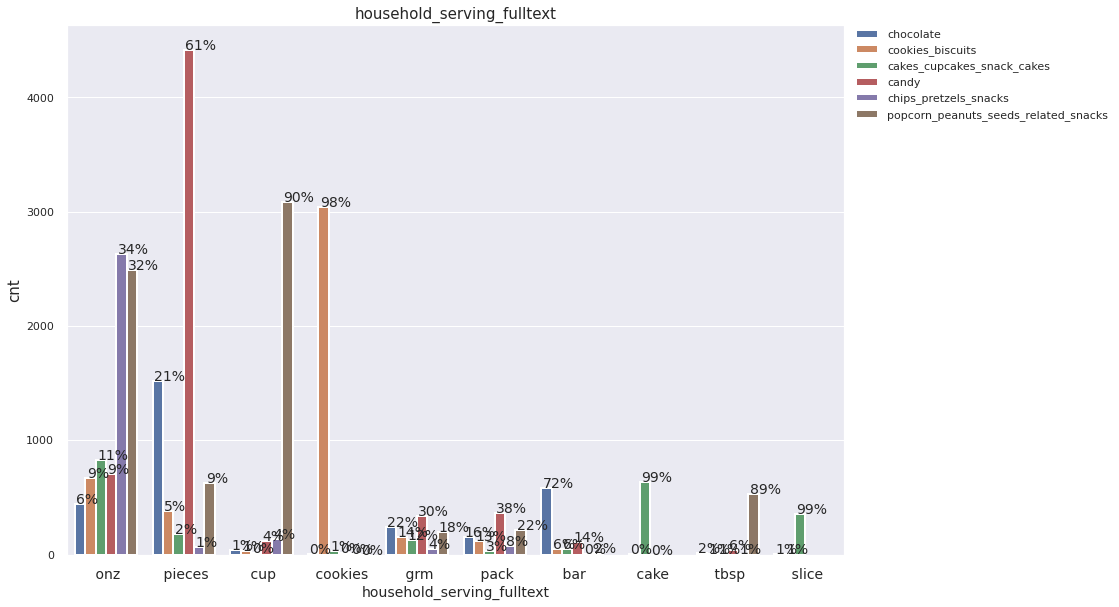

In [20]:
sns.set(rc={'figure.figsize':(15.7,8.27)})
cnt_houshold = food_train.household_serving_fulltext.value_counts()
ax = sns.countplot(x='household_serving_fulltext', data=food_train,
                  # facecolor=(0, 0, 0, 0),
                   linewidth=2,
                   hue = food_train.category,
                   order=food_train.household_serving_fulltext.value_counts().iloc[0:10].index
                   #,legend=False
                  )
#ax.despine(left=True)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.tight_layout()
plt.title("household_serving_fulltext",fontsize=15)
ax.set_xlabel('household_serving_fulltext',fontsize=14)
ax.set_ylabel('cnt',fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

with_hue(ax, food_train.household_serving_fulltext, 10, 6)  

We can see that each houshold value have different distribution from another which means it might be a good feature :)

In [21]:
print('# Unique values of household_serving_fulltext: ',len(food_train.household_serving_fulltext.unique()))

# Unique values of household_serving_fulltext:  572


## Augmented feature

We can hypothesize that units that measure quantity/volume/weight contain distinctive information about the label, different than units that count items.<br> Let's see if it make sense.

In [39]:
food_train = add_is_houshold_unit(food_train)

In [40]:
df_h = pd.DataFrame(food_train.groupby('category')['is_houshold_unit'].value_counts())

In [41]:
column_name = 'is_houshold_unit'
keywords = [0,1]
keywords_dict = {}
categories = ['cakes_cupcakes_snack_cakes','candy','chips_pretzels_snacks','chocolate','cookies_biscuits','popcorn_peanuts_seeds_related_snacks']
for word in keywords:
    keywords_dict[word] = {}
    word_dict = {}
    for category in categories:
        category_cnt = sum(food_train[column_name][food_train.category == category].map(lambda a: 1 if a == word else 0))
        keywords_dict[word][category] = category_cnt


In [42]:
df_houshold_unit = pd.DataFrame(keywords_dict)
df_houshold_unit_t = df_houshold_unit.T

<AxesSubplot:title={'center':'Category per Is Houshold Unit'}>

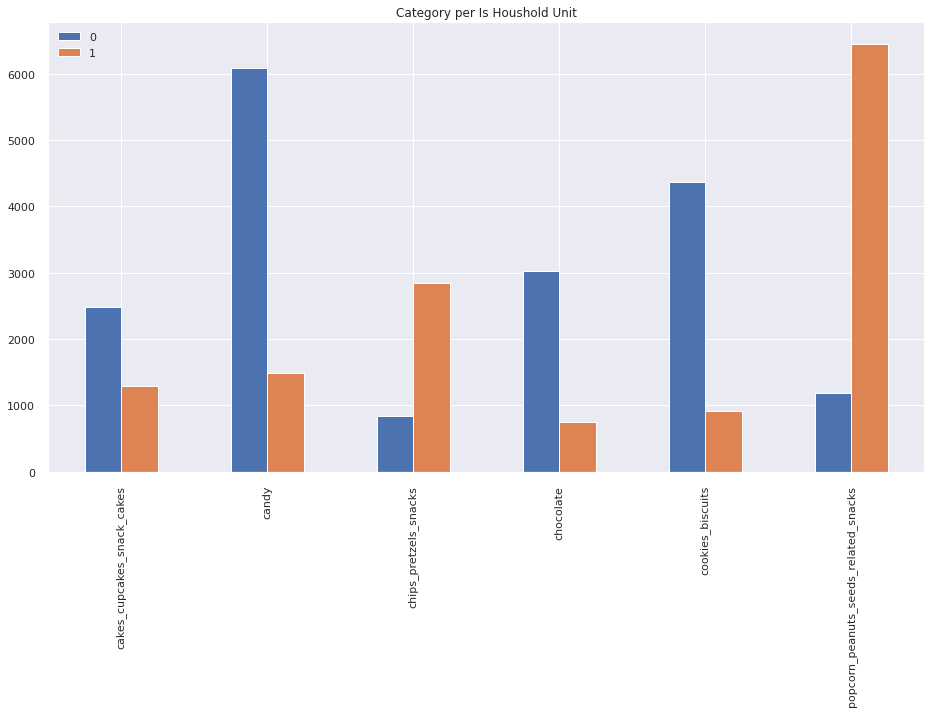

In [43]:
df_houshold_unit.plot(kind = 'bar',title = 'Category per Is Houshold Unit')

We see that this feature has some information about the label (e.g. popcorn_etc category is dominated by units that are quantity based)<br>
So we will try to add it as a feature.

#### Basic cleaning

In [55]:
food_train['description'] = food_train.description.map(lambda a: preprocess(a))

Let's check if there is a difference in the #words between the different categories.

In [10]:
food_train['# description words'] = food_train.description.str.count(' ') + 1
food_train[['description','# description words']].sort_values(by='# description words', ascending=True)
food_train.groupby('category')['# description words'].mean()

category
cakes_cupcakes_snack_cakes              4.062071
candy                                   4.436973
chips_pretzels_snacks                   4.953261
chocolate                               5.128314
cookies_biscuits                        4.546177
popcorn_peanuts_seeds_related_snacks    4.524264
Name: # description words, dtype: float64

We see that there is a small difference between the different categories - maybe it can be a feature.<br>
We will check it on the data for this decision.

#### Word Frequency

After stemmimg and removing 'stop words' we would like to see the affect frequency of top n words on the category distribution.<br>
Let's take a look on the cleaned descriptions.

In [76]:
full_description_word_list = get_full_description_word_list(food_train)
print('# Words in descriptions: ',len(full_description_word_list))
print('# Unique Words in descriptions: ',len(set(full_description_word_list)))

# Words in descriptions:  137943
# Unique Words in descriptions:  5898


In [56]:
food_train.description.to_list()[0:20]

[' milk chocol',
 ' frost sugar cooki',
 ' white frost mini sugar cooki',
 ' chocolati dip graham cracker',
 ' ferrero collect fine assort confect',
 ' kroger chipmat cooki chocol chip',
 ' chocol chip cooki',
 ' spaan sugar free spice windmil cooki',
 ' cinnamon swirl slice creme cake',
 ' laffi taffi',
 ' organ yellow corn tortilla chip',
 ' plain browni bite',
 ' slice loaf cake',
 ' cougar mountain blueberri oat natur soft cooki',
 ' tasti chocol chip cooki',
 ' organ chocol cooki',
 ' erewhon organ cinnamon graham honey',
 ' walnut halv piec',
 ' angel food cake',
 ' american golden roast salt pepita']

By quick look we see that 'cooki' (stemmed cookies or cookie) repeats a lot.<br>
What will be the most repeated word and will it show label separation?<br>
We will take the most repeated 10 words by each category so we won't be affected by class imbalance.

In [58]:
description_keywords_dict_top_10 = {category: get_column_top_n_word_count_by_category('description',category,food_train,10) for category in categories}
description_keywords_top_10 = set(sum(description_keywords_dict_top_10.values(), []))

In [61]:
description_keywords = get_keywords_dictionary(description_keywords_top_10,'description')
description_keywords_df = pd.DataFrame(description_keywords)
df_t = description_keywords_df.T
df_t['sum'] = df_t[list(df_t.columns)].sum(axis=1)
df_t = df_t.sort_values(by=['sum'], ascending=False)
df_t = df_t.drop(columns=['sum'])

The top 10 words by each category leaves us with only 43 key words. Let's examine their frequency per caterogy to see if they contain distinctive information (not spread out evenly across categories)

In [62]:
len(description_keywords)

43

<AxesSubplot:title={'center':'Stacked Bar Graph'}>

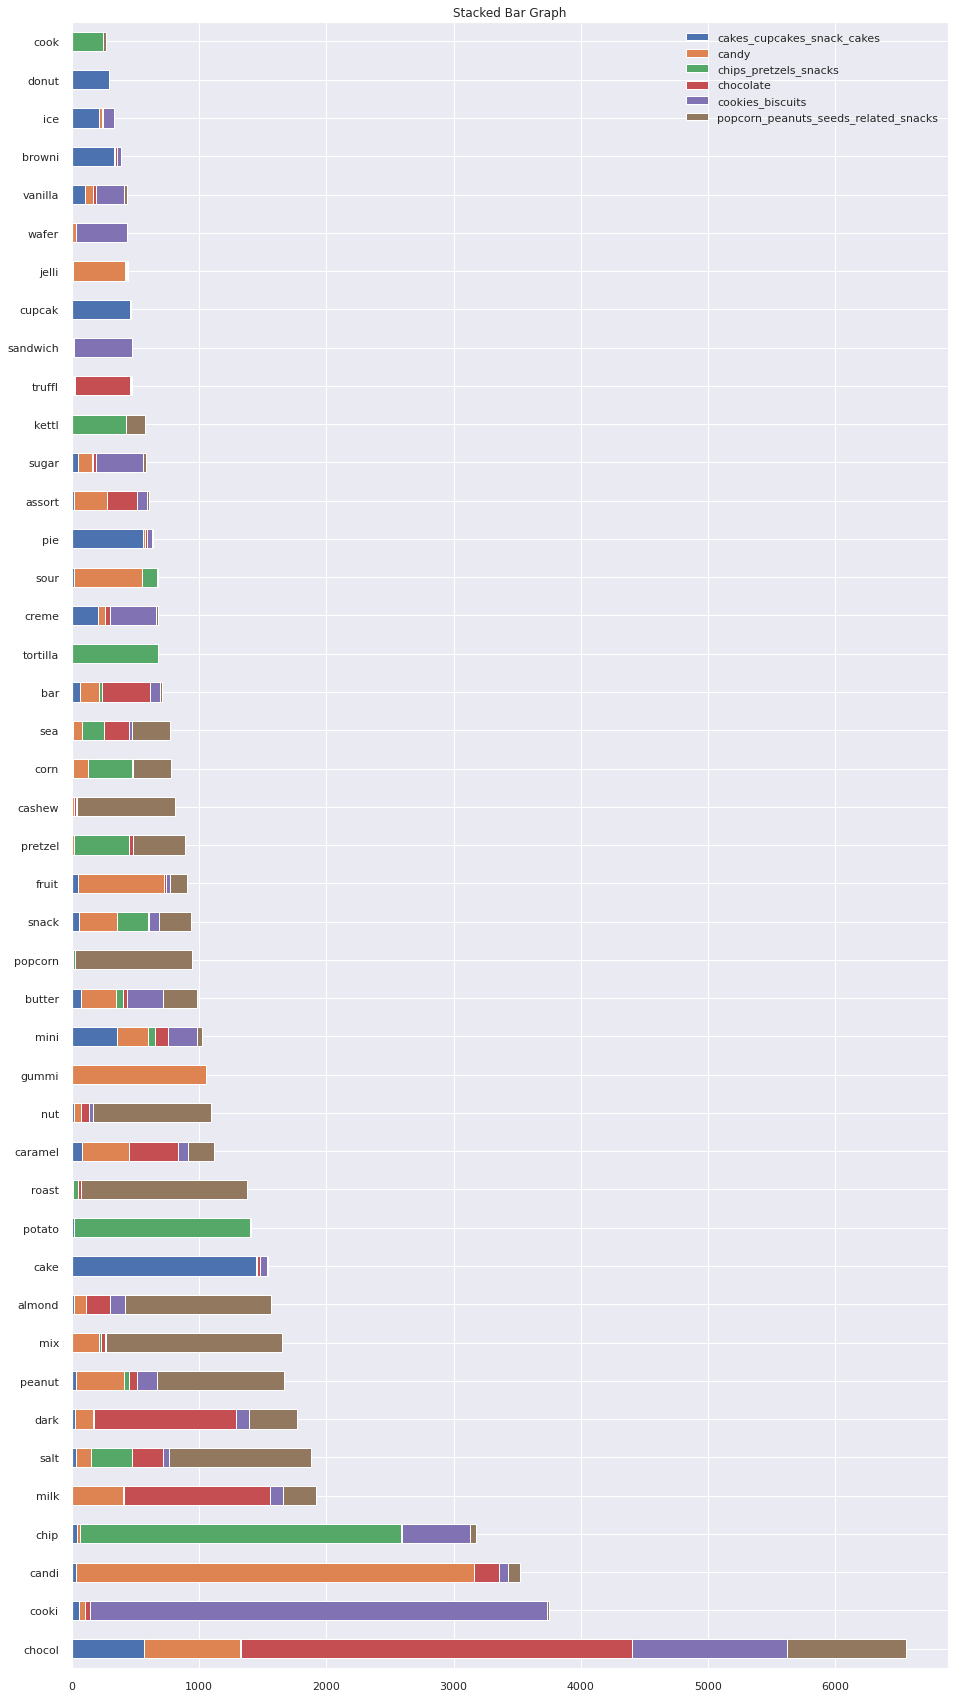

In [65]:
sns.set(rc={'figure.figsize':(15.7,30.27)})
df_t.plot(
    x = df_t.index.name,
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    mark_right = True)


So the most frequent word is 'chocol' (stemmed 'chocolate' or 'chocolaty' etc...):<br>
Most of it's apperences belongs to the chocolate category and the least of it's appearences belongs to cakes category.<br>
The are many words that almost completly colored by one category as 'cooki', 'candi','cake','potato' etc.<br>
This shows very well the impact of appearence each word in the description, which can be a binary feature.

### Ingredients

We apply some basic cleaning to the list of ingredients.

In [6]:
food_train.ingredients = food_train.ingredients.map(lambda a: clean_ingredients(a))

In [11]:
full_ingredients = get_full_ingredients_list(food_train)
print('#Ingredients in all snacks: ',len(full_ingredients))
print('# Unique Ingredients in all snacks: ',len(set(full_ingredients)))

#Ingredients in all snacks:  333592
# Unique Ingredients in all snacks:  31186


Let's take a look at # ingredients per category.

In [3]:
food_train['# ingredients'] = food_train.ingredients.str.count(',') + 1

In [7]:
food_train.groupby('category')['# ingredients'].mean()

category
cakes_cupcakes_snack_cakes              40.894472
candy                                   12.801055
chips_pretzels_snacks                   12.588747
chocolate                               15.167374
cookies_biscuits                        22.158682
popcorn_peanuts_seeds_related_snacks    10.799213
Name: # ingredients, dtype: float64

We see a clear difference between the different categories and cakes and cupcake appearently have the most ingredients in it.<br>

Let's take a look on the first ingredient only (which is contained the most).

In [8]:
food_train[['first_ingredient','second+_ingredients']] = food_train.ingredients.str.split(',',n=1,expand=True)

In [9]:
print('unique first ingredient values in the dataset: ',len(set(food_train.first_ingredient)))

unique first ingredient values in the dataset:  2885


#### First Ingredient Frequency By Category

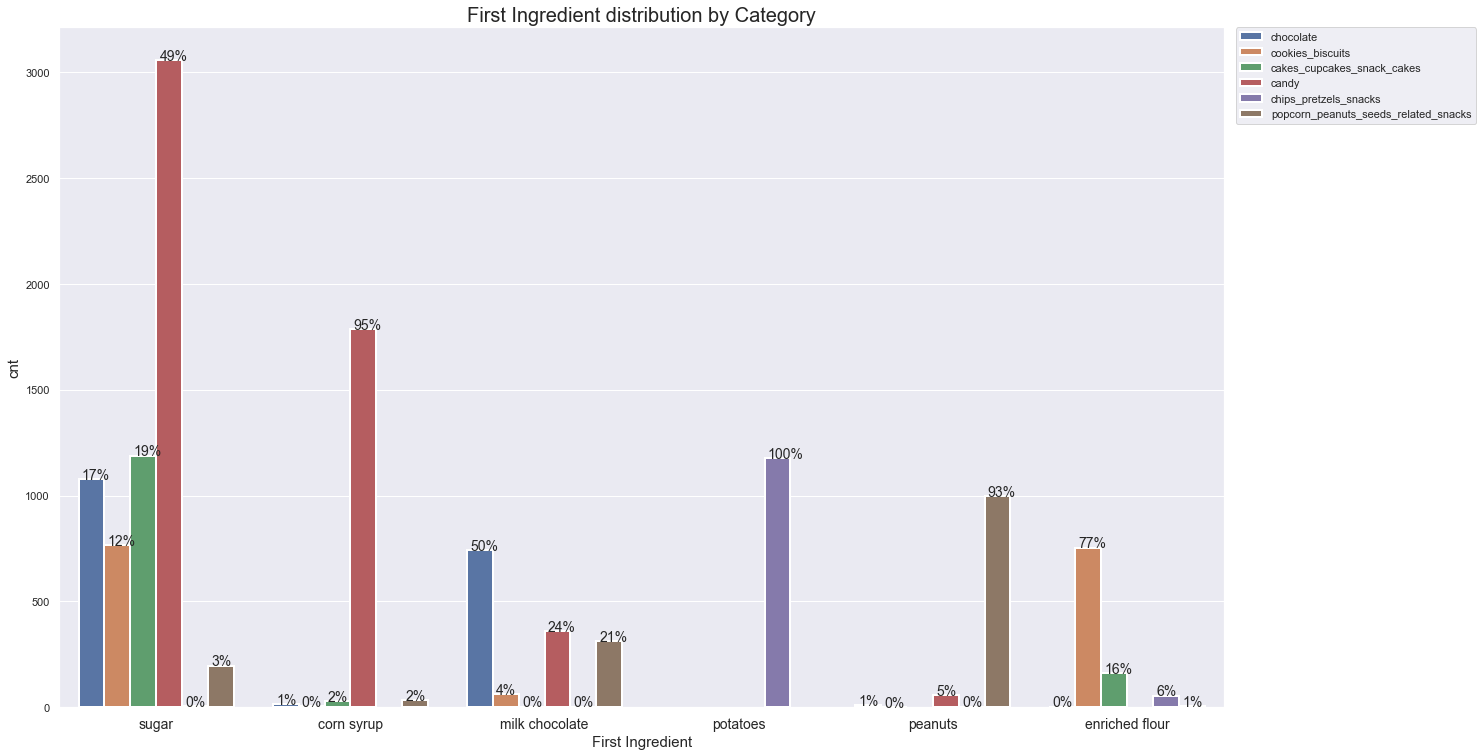

In [10]:
sns.set(rc={'figure.figsize':(20.7,10.27)})

ax = sns.countplot(x='first_ingredient', data=food_train,
                  # facecolor=(0, 0, 0, 0),
                   linewidth=2,
                   hue = food_train.category,
                   order=food_train.first_ingredient.value_counts().iloc[:6].index
                   #,legend=False
                  )
#ax.despine(left=True)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.tight_layout()
plt.title("First Ingredient distribution by Category",fontsize=20)
ax.set_xlabel('First Ingredient',fontsize=15)
ax.set_ylabel('cnt',fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)


with_hue(ax, food_train.first_ingredient, 6, 6)    


We see that each first ingredient has completly different distribution of categories.<br>
Interesting to see that Popcorn almost have no sugar in it's first ingredient, unlike the other categories.

#### Different Shades Of Flour 

Let's examine the 'flour' variations of the first ingredient.

In [11]:
print('Unique first ingredient contain \'flour\' values in the dataset: ',len(set(food_train.first_ingredient[food_train.first_ingredient.str.contains("flour")])))


Unique first ingredient contain 'flour' values in the dataset:  295


There are many kinds of flour in our data set, let's see what is the category distribution of the top values of first ingredient with 'flour'.

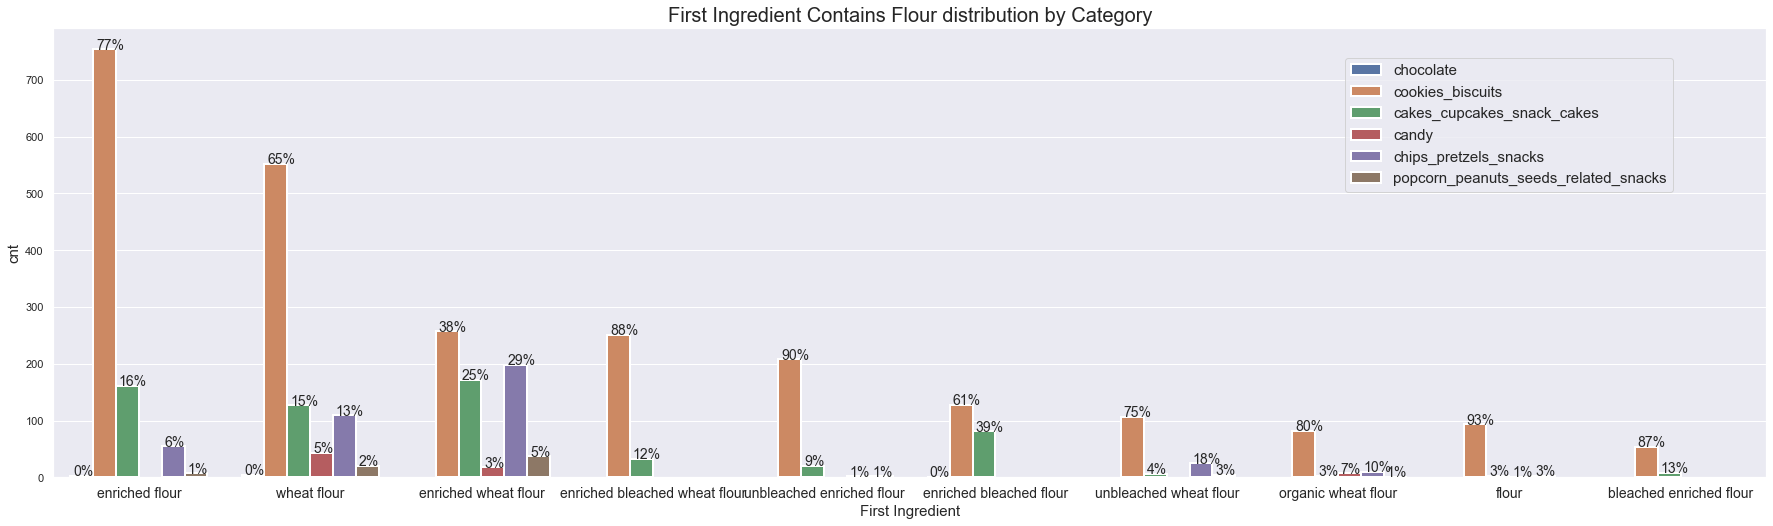

In [13]:
sns.set(rc={'figure.figsize':(30.7,8.27)})

ax = sns.countplot(x=food_train.first_ingredient, data=food_train,
                   # facecolor=(0, 0, 0, 0),
                   linewidth=2,
                   hue = food_train.category,
                   order=food_train.first_ingredient[food_train.first_ingredient.str.contains("flour")].value_counts().iloc[0:10].index
                   #,legend=False
                  )
plt.legend(loc='upper right', bbox_to_anchor=(0.95, 0.95), fontsize=15)
#plt.tight_layout()
plt.title("First Ingredient Contains Flour distribution by Category",fontsize=20)
ax.set_xlabel('First Ingredient',fontsize=15)
ax.set_ylabel('cnt',fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)

with_hue(ax, food_train.first_ingredient[food_train.first_ingredient.str.contains("flour")], 10, 6) 

It can make sense to combine them all,<br>
the distribution of each flour ingredient is kind of similiar.

### Exploring Brand

In [130]:
food_train.brand.value_counts()[0:20]

wal-mart stores                 581
target stores                   540
ferrara candy company           506
not a branded item              467
meijer                          463
cvs pharmacy                    342
the kroger co                   340
walgreens co                    336
topco associates                320
ahold usa                       291
hy-vee                          276
russell stover candies          273
mars chocolate north america    268
safeway                         222
tops markets                    217
supervalu                       211
whole foods market              206
weis markets                    205
giant eagle                     203
wegmans food markets            202
Name: brand, dtype: int64

In [22]:
food_train = clean_brand(food_train)
print("# Unique Brands:", len(food_train.brand.unique()))

# Unique Brands: 4651


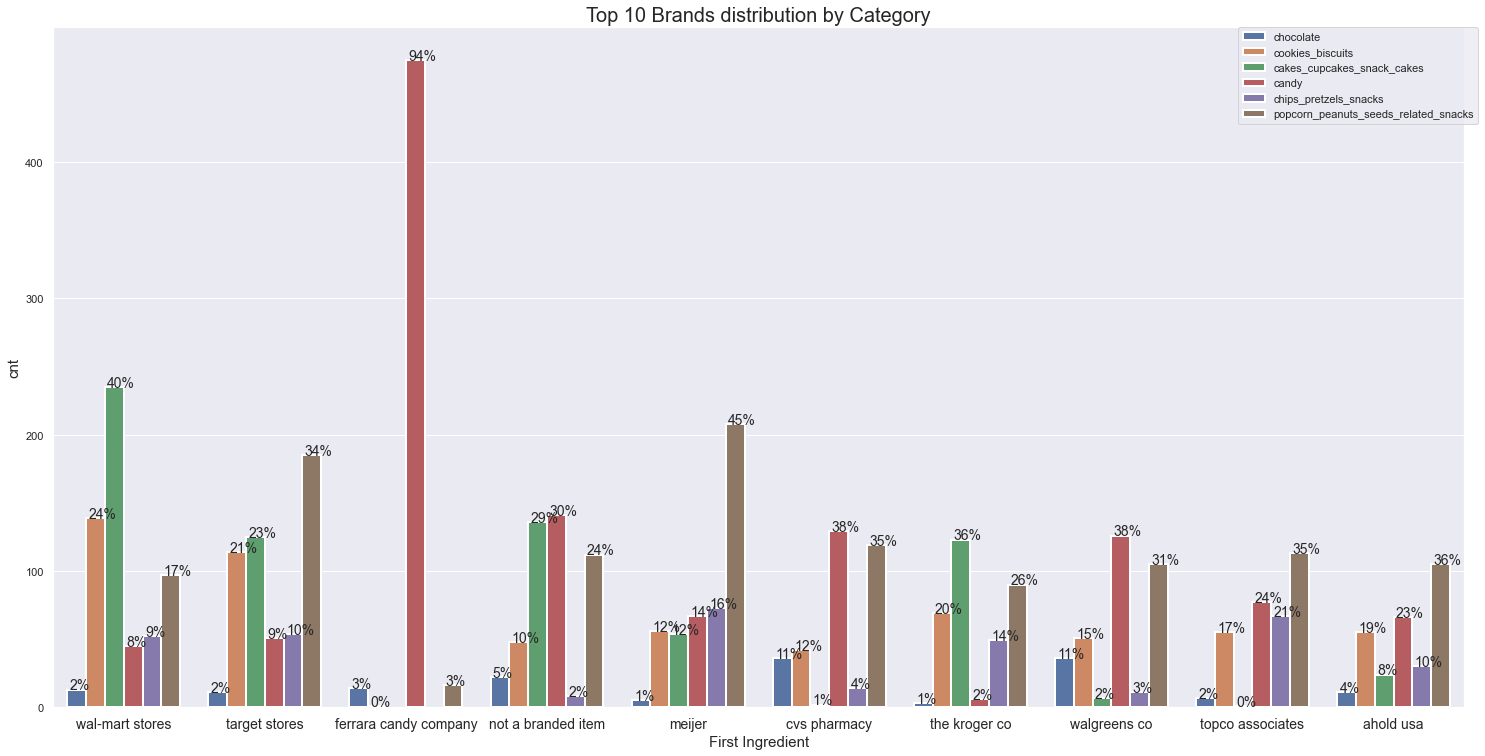

In [24]:
sns.set(rc={'figure.figsize':(20.7,10.27)})

ax = sns.countplot(x='brand', data=food_train,
                  # facecolor=(0, 0, 0, 0),
                   linewidth=2,
                   hue = food_train.category,
                   order=food_train.brand.value_counts().iloc[:10].index
                   #,legend=False
                  )
#ax.despine(left=True)
plt.legend(bbox_to_anchor=(1.01, 1),
           borderaxespad=0)
plt.tight_layout()
plt.title("Top 10 Brands distribution by Category",fontsize=20)
ax.set_xlabel('First Ingredient',fontsize=15)
ax.set_ylabel('cnt',fontsize=15)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)


with_hue(ax, food_train.brand, 10, 6)    


We see there is a difference in the category distribution between the different brands.

### grm Serving Size 

Let's Create grm_serving_size by multiply the ml by 1000.

In [28]:
food_train['grm_serving_size'] = food_train.apply((lambda a: 1000*a.serving_size if a.serving_size_unit == 'ml' else a.serving_size),axis=1)

In [29]:
food_train['grm_serving_size'].describe()

count     31751.000000
mean         59.365651
std        2767.738872
min           0.225000
25%          28.000000
50%          30.000000
75%          40.000000
max      480000.000000
Name: grm_serving_size, dtype: float64

Maybe it's worth to do log transformation to see the distribution better.

In [ ]:
food_train['scaled_serving_size'] = np.log(food_train.grm_serving_size)

#### Scaled Serving Size Per Category

Text(0.5, 1.0, 'Scaled serving size')

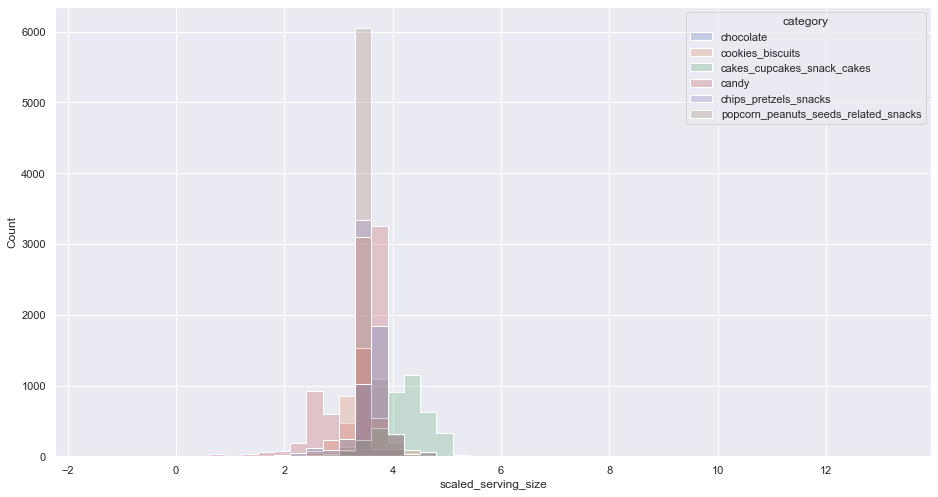

In [74]:
sns.histplot(data=food_train, x='scaled_serving_size',hue = 'category', stat='count', edgecolor=None, binwidth=0.3, element="step")
ax.set_title('Scaled serving size')

We definitely see that each category has a particular serving size distribution:<br> e.g. candy has mostly lower values, while 'cake' has mostly higher values.

## Nutrients Data Set

In [5]:
food_nutrients_full= pd.merge(pd.merge(food_nutrients, nutrients, on="nutrient_id"), food_train[['idx','category']], on="idx")

<AxesSubplot:title={'center':'Category per Nutrient Unit'}>

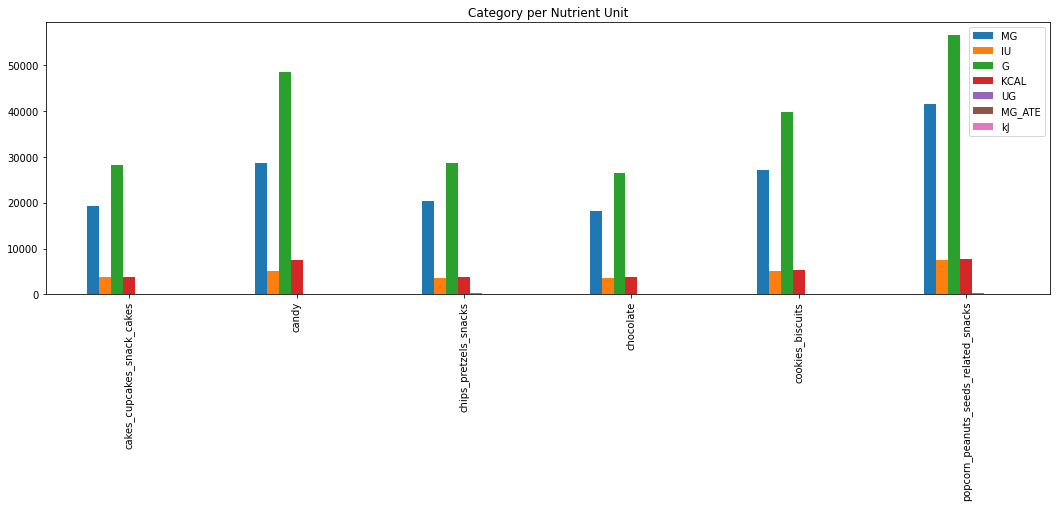

In [12]:
column_name = 'unit_name'
keywords = food_nutrients_full.unit_name.unique()
keywords_dict = {}
categories = ['cakes_cupcakes_snack_cakes','candy','chips_pretzels_snacks','chocolate','cookies_biscuits','popcorn_peanuts_seeds_related_snacks']
for word in keywords:
    keywords_dict[word] = {}
    word_dict = {}
    for category in categories:
        category_cnt = sum(food_nutrients_full[column_name][food_nutrients_full.category == category].map(lambda a: 1 if a == word else 0))
        keywords_dict[word][category] = category_cnt
df_nutrient_unit = pd.DataFrame(keywords_dict)
df_nutrient_unit_t = df_nutrient_unit.T
df_nutrient_unit.plot(kind = 'bar',title = 'Category per Nutrient Unit',figsize=(18,5))

looking at the nutrient unit name, it doesn't seem to have the best information about category inside.
Therefore we decide to use only the amount of each nutrient.

## Food Nutrients Data Set

In [219]:
print ( "# Unique Nutrients:" ,len(food_nutrients.nutrient_id.unique()))

# Unique Nutrients: 48


In [ ]:
food_nutrients_joined = pd.merge(pd.get_dummies(food_nutrients.pivot(index='idx', columns='nutrient_id', values='amount').iloc[: ,0:49]).add_prefix('nutrient_'), food_train, on="idx")
food_nutrients_joined.fillna(0)

Let's take a look at Protein nutrient (id 1003).

In [23]:
food_nutrients_joined['nutrient_1003'].describe()

count    31722.000000
mean         6.975735
std          6.325881
min          0.000000
25%          3.330000
50%          5.260000
75%          8.000000
max        100.000000
Name: nutrient_1003, dtype: float64

We don't need to scale the nutrients becuase we will use Tree model.

<AxesSubplot:xlabel='nutrient_1003', ylabel='Count'>

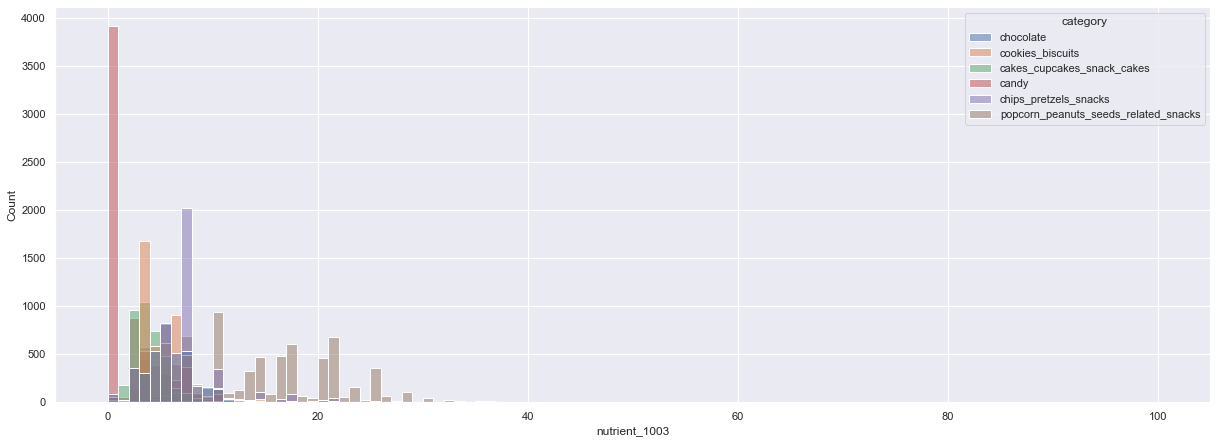

In [24]:
sns.set(rc={'figure.figsize':(20.7,7.27)})
sns.histplot(data=food_nutrients_joined, x='nutrient_1003', edgecolor=None,hue = 'category', binwidth=1)

We see that for some values there is almost absolute category seperation.

## Exploring the Images Data Set 

cakes_cupcakes_snack_cakes 3786
chocolate 3772
candy 7584
cookies_biscuits 5284
chips_pretzels_snacks 3680
popcorn_peanuts_seeds_related_snacks 7645


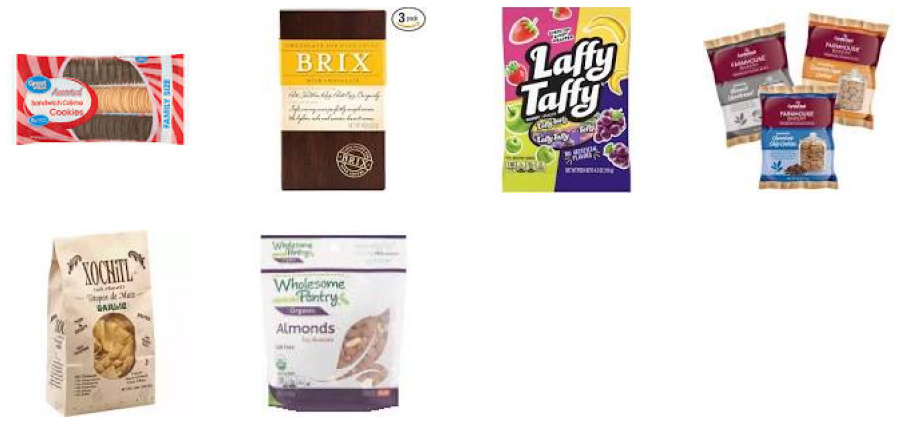

In [241]:
train_dir = './foods_final/train'
categories = ['cakes_cupcakes_snack_cakes',  'chocolate', 'candy', 'cookies_biscuits',
'chips_pretzels_snacks', 'popcorn_peanuts_seeds_related_snacks']
nrows = len(categories)
ncols = 4
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
for i,cat in enumerate(categories):
    cat_dir = os.path.join(train_dir,cat)
    train_names = os.listdir(cat_dir)
    print(cat, len(train_names))
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    pic_path = os.path.join(cat_dir, train_names[0])
    img = mpimg.imread(pic_path)
    plt.imshow(img)
    
plt.show()   

#### Average image per category

Let's take a look on the average picture per category - the average is done per pixel.

In [ ]:
# reference from https://towardsdatascience.com/exploratory-data-analysis-ideas-for-image-classification-d3fc6bbfb2d2

In [267]:
dict_of_images_file_lists = { category : [f for f in listdir(f'{train_dir}/{category}/') ] for category in categories }
dict_of_category_images = {category: img2np(f'{train_dir}/{category}/', dict_of_images_file_lists[category]) for category in categories}

In [302]:
def find_mean_img(full_mat, title, size = (140, 140)):
    # calculate the average
    mean_img = np.mean(full_mat, axis = 0)
    # reshape it back to a matrix
    mean_img = mean_img.reshape(size)
    plt.imshow(mean_img, vmin=0, vmax=255)#, cmap='Greys_r')
    plt.title(f'Average {title}')
    plt.axis('off')
    plt.show()
    return mean_img



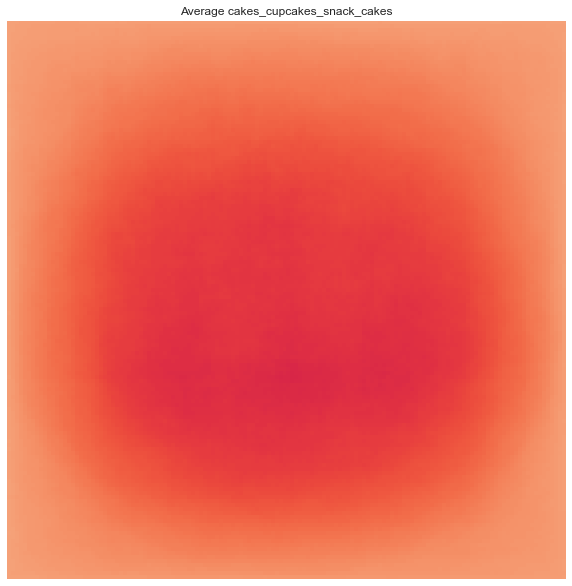

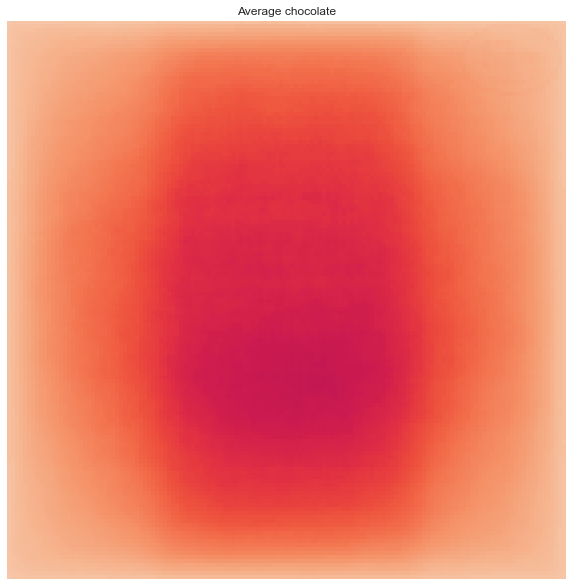

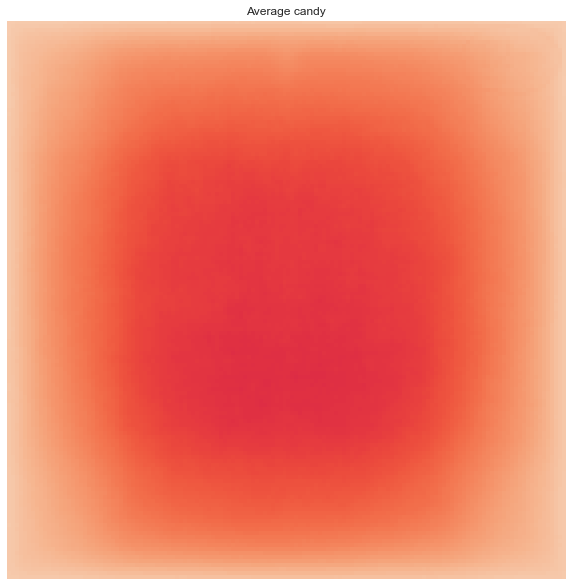

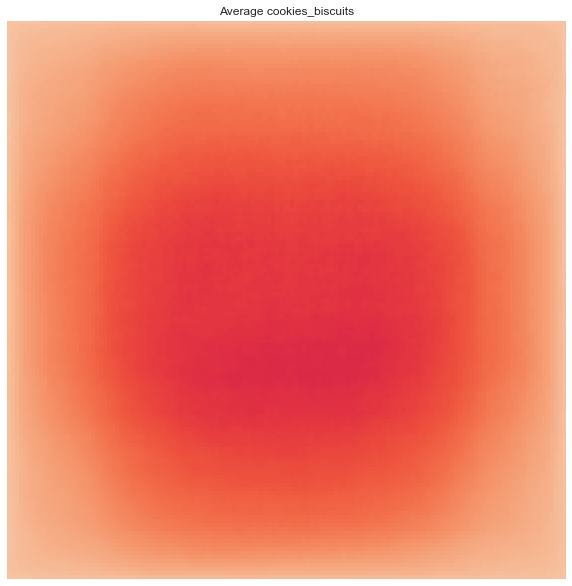

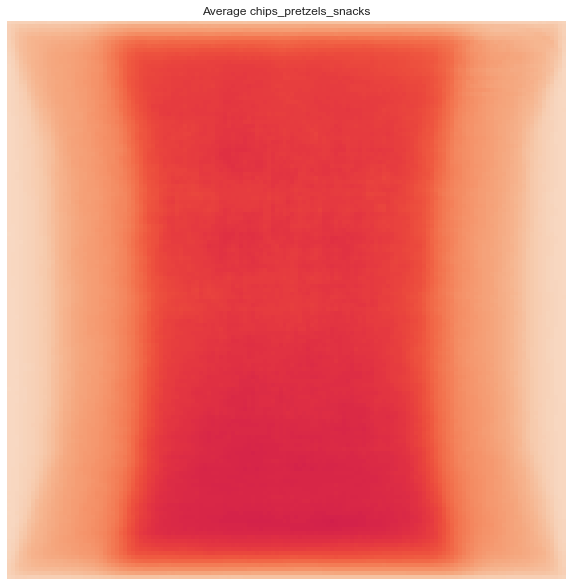

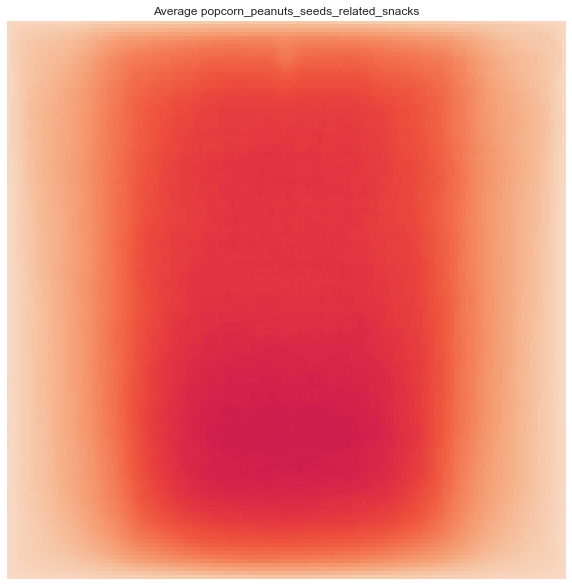

In [303]:
dict_of_image_mean= {category: find_mean_img( dict_of_category_images[category], category) for category in categories }

Apperently there is no much difference on the averaged picture per category...
If you try hard you will be able to imagine a bag of chips from the avrage chips_pretzel snack.

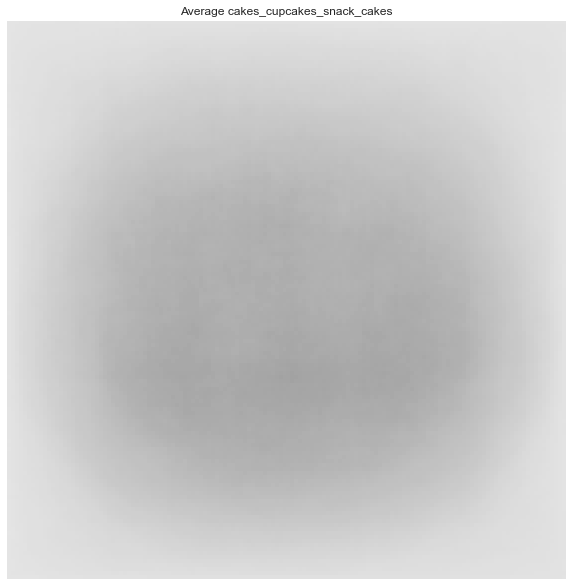

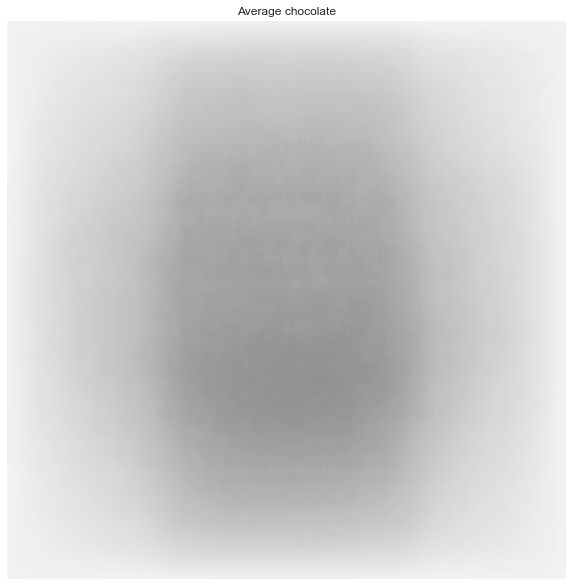

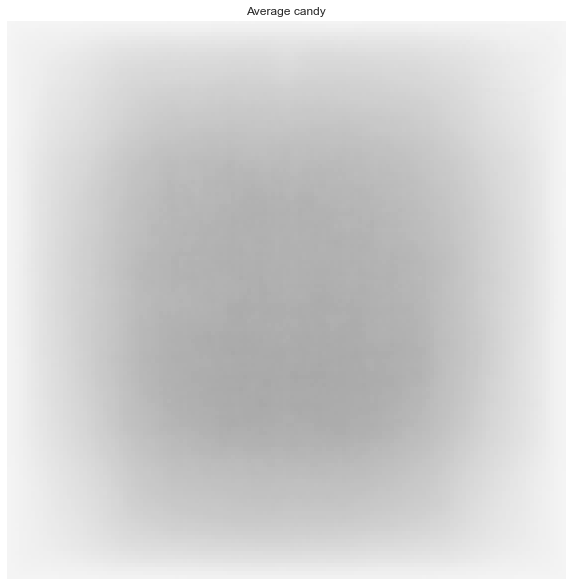

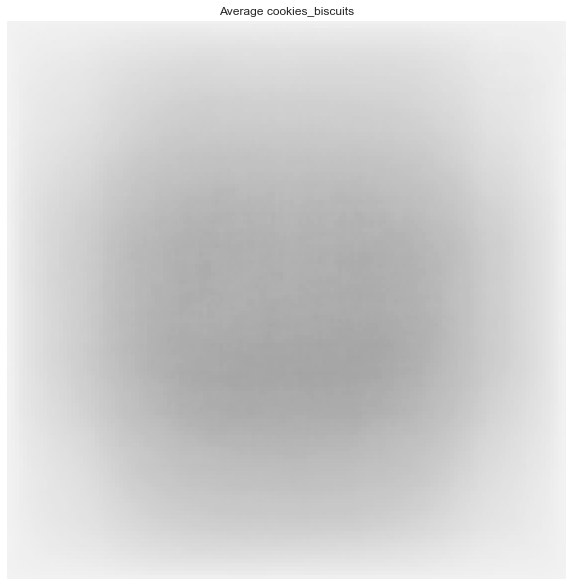

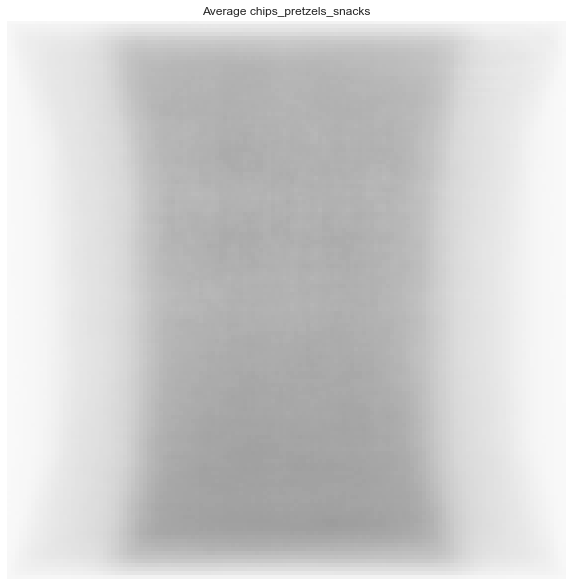

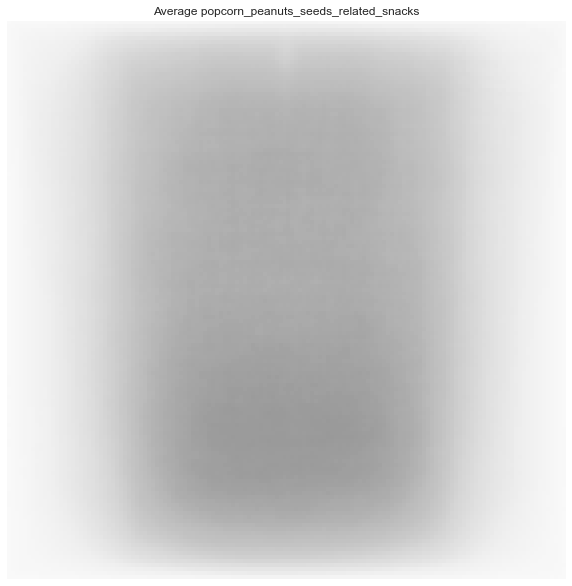

In [282]:
dict_of_image_mean = {category: find_mean_img( dict_of_category_images[category], category) for category in categories }

In [304]:
from sklearn.decomposition import PCA
from math import ceil

def eigenimages(full_mat, title, n_comp = 0.7, size = (140, 140)):
    # fit PCA to describe n_comp * variability in the class
    pca = PCA(n_components = n_comp, whiten = True)
    pca.fit(full_mat)
    print('Number of PC: ', pca.n_components_)
    return pca
  
def plot_pca(pca, size = (140, 140)):
    # plot eigenimages in a grid
    n = pca.n_components_
    fig = plt.figure(figsize=(8, 8))
    r = int(n**.5)
    c = ceil(n/ r)
    for i in range(n):
        ax = fig.add_subplot(r, c, i + 1, xticks = [], yticks = [])
        ax.imshow(pca.components_[i].reshape(size))
                 # , cmap='Greys_r')
    plt.axis('off')
    plt.show()

#### Eigenimages to visualize the components that describe each class the best

Number of PC:  25


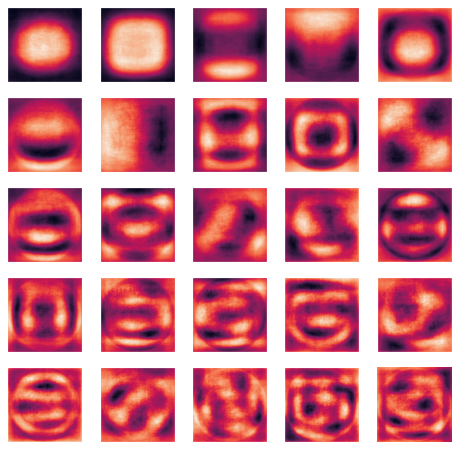

Number of PC:  24


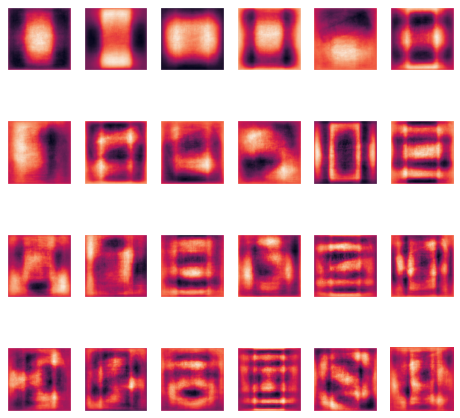

Number of PC:  45


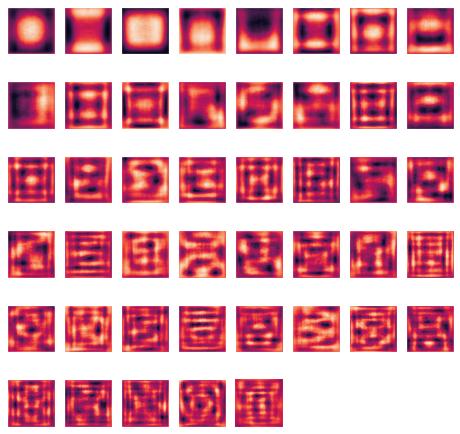

Number of PC:  32


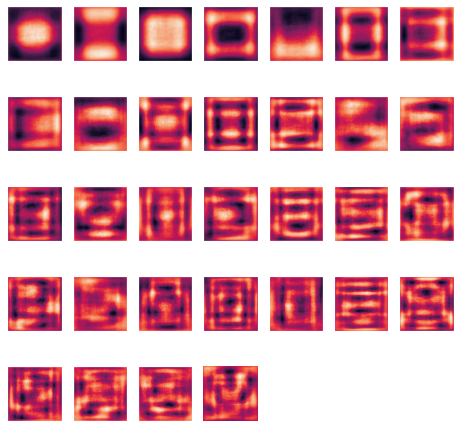

Number of PC:  36


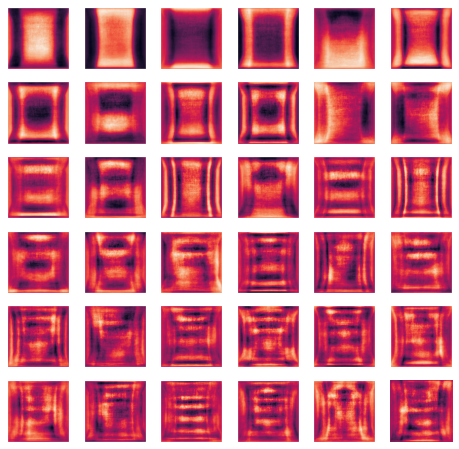

Number of PC:  31


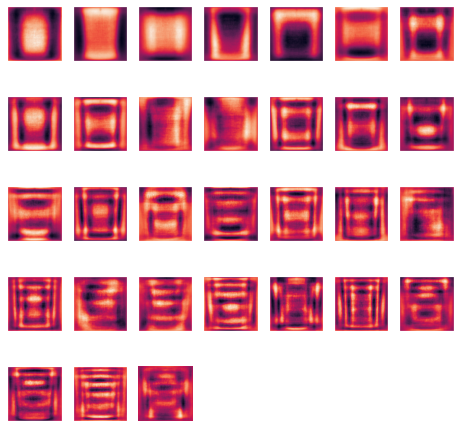

In [305]:
dict_of_plot_pca = {category: plot_pca(eigenimages( dict_of_category_images[category], category)) for category in categories }

Number of PC:  25


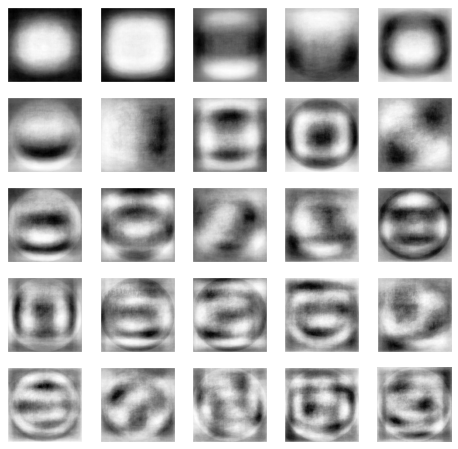

Number of PC:  24


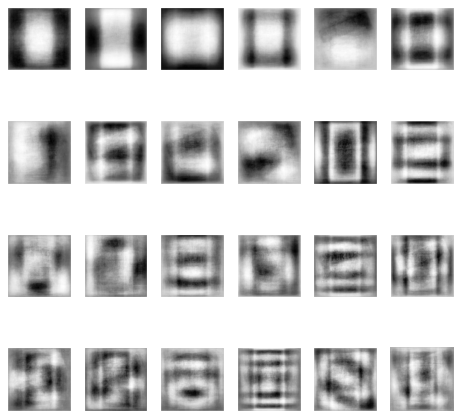

Number of PC:  45


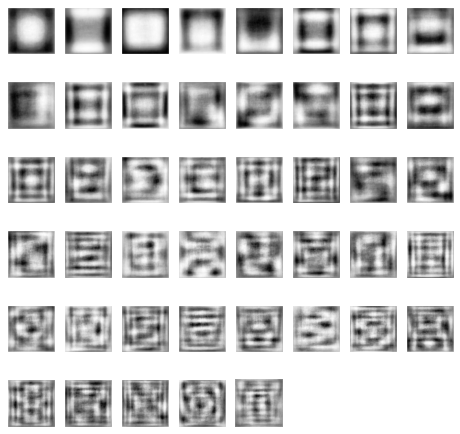

Number of PC:  32


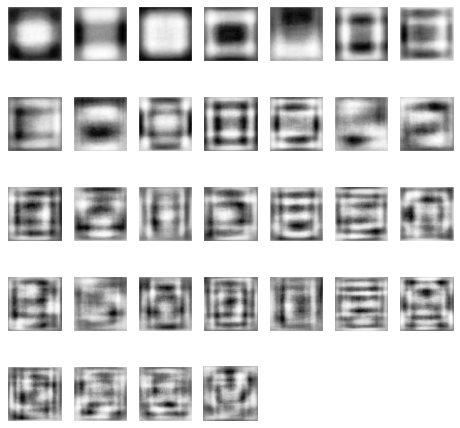

Number of PC:  36


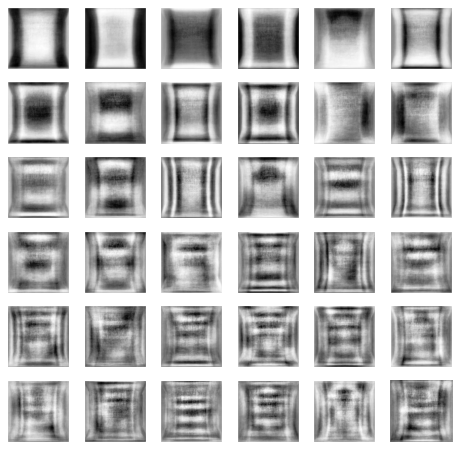

Number of PC:  31


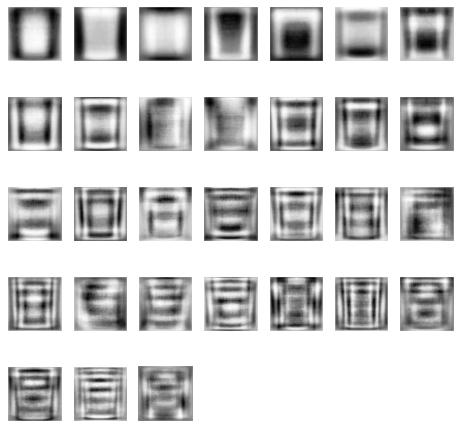

In [301]:
dict_of_plot_pca = {category: plot_pca(eigenimages( dict_of_category_images[category], category)) for category in categories }

We see different components between the categories, but we are not pretend to understand those components, that's why we will use CNN to handle it.